In [98]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
import os 

from sklearn.impute import SimpleImputer, MissingIndicator
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression

from sklearn.metrics import r2_score

warnings.filterwarnings("ignore")

In [51]:
link = r"E:\datasets\car\clean_df.csv"

df = pd.read_csv(link)

In [52]:
df.corr()

,mileage,manufacture_year,engine_displacement,engine_power,stk_year,door_count,seat_count,price_eur
mileage,1.000000,-0.695236,0.216322,0.000369,-0.486847,-0.024099,0.052112,-0.505467
manufacture_year,-0.695236,1.000000,-0.133607,0.067660,0.391681,0.154124,0.032830,0.541981
engine_displacement,0.216322,-0.133607,1.000000,0.780909,-0.071904,-0.022409,0.042308,0.392190
engine_power,0.000369,0.067660,0.780909,1.000000,0.064030,-0.045531,0.011943,0.613308
stk_year,-0.486847,0.391681,-0.071904,0.064030,1.000000,-0.000888,0.017060,0.361007
door_count,-0.024099,0.154124,-0.022409,-0.045531,-0.000888,1.000000,0.395099,0.039982
seat_count,0.052112,0.032830,0.042308,0.011943,0.017060,0.395099,1.000000,0.022842
price_eur,-0.505467,0.541981,0.392190,0.613308,0.361007,0.039982,0.022842,1.000000


### Create man_period, stk_period

In [53]:
df.head()

,maker,model,mileage,manufacture_year,engine_displacement,engine_power,body_type,stk_year,transmission,door_count,seat_count,fuel_type,date_created,date_last_seen,price_eur
0,ford,galaxy,151000.0,2011.0,2000.0,138.12506,compact,NaN,man,5.0,7.0,diesel,2015-11-14 18:10:06.838319+00,2016-01-27 20:40:15.46361+00,10584.75
1,skoda,octavia,143476.0,2012.0,2000.0,108.62262,compact,NaN,man,5.0,5.0,diesel,2015-11-14 18:10:06.853411+00,2016-01-27 20:40:15.46361+00,8882.31
2,bmw,NaN,97676.0,2010.0,1995.0,113.98670,compact,NaN,man,5.0,5.0,diesel,2015-11-14 18:10:06.861792+00,2016-01-27 20:40:15.46361+00,12065.06
3,skoda,fabia,111970.0,2004.0,1200.0,84.48426,compact,NaN,man,5.0,5.0,gasoline,2015-11-14 18:10:06.872313+00,2016-01-27 20:40:15.46361+00,2960.77
4,skoda,fabia,128886.0,2004.0,1200.0,84.48426,compact,NaN,man,5.0,5.0,gasoline,2015-11-14 18:10:06.880335+00,2016-01-27 20:40:15.46361+00,2738.71


In [54]:
df['date_created'] = pd.to_datetime(df['date_created'])
df['year_created'] = df['date_created'].dt.year

df['man_period'] = df['year_created'] - df['manufacture_year']
df['stk_period'] = df['year_created'] - df['stk_year']

In [55]:
df = df.drop(['manufacture_year', 'stk_year', 'date_created', 'date_last_seen', 'year_created'], axis=1)

# Feature processing

In [56]:
X = df.drop('price_eur', axis=1).to_numpy()
y = df['price_eur'].to_numpy()

In [93]:
class Indicator(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        # nonnull_X = X.copy()
        # nonnull_X = nonnull_X.astype(float)
        # nonnull_X[np.isnan(nonnull_X )] = 0
        nonnull_X = np.nan_to_num(X.astype(float), nan=0).astype(int)

        missing_indicator = MissingIndicator()
        indicator_values = missing_indicator.fit_transform(X).astype(int)

        return np.c_[nonnull_X, indicator_values]

In [91]:
arr = np.array([1.0, 2.0, np.nan, 4.0, np.nan, 6.0])
arr = X[:,2].astype(float)
fill_value = 0
arr_filled = np.nan_to_num(arr, nan=fill_value)
arr_filled

array([151000., 143476.,  97676., ...,  86000., 123000., 190240.])

In [92]:
arr_filled.astype(int)

array([151000, 143476,  97676, ...,  86000, 123000, 190240])

In [94]:
num_cols = [2,3,4,7,8,10,11]
cat_cols = [0,1,5,6,7,9]

one_hot_encoder = OneHotEncoder(handle_unknown='error')
indicator = Indicator()

full_pipeline = ColumnTransformer([
    ("num", indicator, num_cols),
    ("cat", one_hot_encoder, cat_cols),
])

In [95]:
full_pipeline.fit(X)
X_trans = full_pipeline.transform(X)

ColumnTransformer(transformers=[('num', Indicator(), [2, 3, 4, 7, 8, 10, 11]),
                                ('cat', OneHotEncoder(), [0, 1, 5, 6, 7, 9])])

In [97]:
lin_reg = LinearRegression(fit_intercept=True)
lin_reg.fit(X_trans,y)

LinearRegression()

In [99]:
y_pred = lin_reg.predict(X_trans)

In [102]:
r2_score(y_pred, y)

0.518197511717302

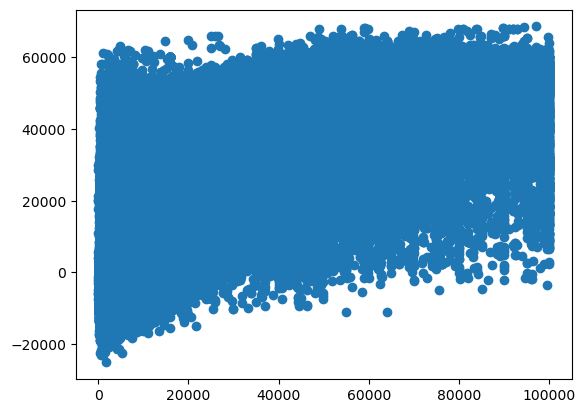

In [103]:
plt.scatter(y, y_pred)